蒸留検証

In [1]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.layers.core import Activation

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
im_width = 128
im_height = 128
im_chan = 1
path_train = "./data/kaggle/train/"
path_test = './data/kaggle/test/'

In [3]:
# 特定のディレクトリのファイルをリストで読み込む
train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+"images"))[2]

In [4]:
# test imgase , masks のサイズ変更
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.bool)
print("Getting and resizing train images and masks ...")

#sys.stdout.flush()
# tqdm_notebook 進捗表示関数

for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    path = path_train
    # 画像のロード
    img = load_img(path+"/images/"+id_)
    # RGBの3チャンネルとれるので1チャンネルを取得
    x = img_to_array(img)[:,:,1]
    x = resize(x, (128, 128, 1), mode="constant", preserve_range=True)
    X_train[n] = x
    mask = img_to_array(load_img(path + "/masks/" + id_))[:,:,1]
    Y_train[n] = resize(mask, (128, 128, 1), mode="constant", preserve_range=True)

print("Done!")

Getting and resizing train images and masks ...


C:\Users\G2\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



Done!


In [5]:
# IoUメトリックを定義する
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [22]:
def theacher_model():
    # Bulid U-Net model
    # shape(128, 128, 1)
    inputs = Input((im_height, im_width, im_chan))
    # 画素値を0～1に変換
    s = Lambda(lambda x:x /255)(inputs)

    # フィルタ:(3✕3) フィルタ数:8
    # N_out = (N_in + 2P - F)/s +1 
    #          = (128 +0 - 2)/2 + 1 
    #          = 64
    tc1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
    tc1 = Conv2D(8, (3, 3), activation='relu', padding='same') (tc1)
    tp1 = MaxPooling2D((2, 2)) (tc1)
    # shape(64,64,8)

    # N_in(64,64,8)
    tc2 = Conv2D(16, (3, 3), activation='relu', padding='same') (tp1)
    tc2 = Conv2D(16, (3, 3), activation='relu', padding='same') (tc2)
    tp2 = MaxPooling2D((2, 2)) (tc2)
    # N_out(32,32,16)

    tc3 = Conv2D(32, (3, 3), activation='relu', padding='same') (tp2)
    tc3 = Conv2D(32, (3, 3), activation='relu', padding='same') (tc3)
    tp3 = MaxPooling2D((2, 2)) (tc3)
    # N_out(16, 16, 32)

    tc4 = Conv2D(64, (3, 3), activation='relu', padding='same') (tp3)
    tc4 = Conv2D(64, (3, 3), activation='relu', padding='same') (tc4)
    tp4 = MaxPooling2D(pool_size=(2, 2)) (tc4)
    # N_out(8,8,64)

    tc5 = Conv2D(128, (3, 3), activation='relu', padding='same') (tp4)
    tc5 = Conv2D(128, (3, 3), activation='relu', padding='same') (tc5)
    # N_out(8, 8, 128)

    tu6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (tc5)
    tu6 = concatenate([tu6, tc4])
    tc6 = Conv2D(64, (3, 3), activation='relu', padding='same') (tu6)
    tc6 = Conv2D(64, (3, 3), activation='relu', padding='same') (tc6)
    # N_out(16,16, 64)

    tu7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (tc6)
    tu7 = concatenate([tu7, tc3])
    tc7 = Conv2D(32, (3, 3), activation='relu', padding='same') (tu7)
    tc7 = Conv2D(32, (3, 3), activation='relu', padding='same') (tc7)
    # N_out(32,32, 32)

    tu8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (tc7)
    tu8 = concatenate([tu8, tc2])
    tc8 = Conv2D(16, (3, 3), activation='relu', padding='same') (tu8)
    tc8 = Conv2D(16, (3, 3), activation='relu', padding='same') (tc8)
    # N_out(64, 64, 16)

    tu9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (tc8)
    # N_out(128, 128, 8)
    tu9 = concatenate([tu9, tc1], axis=3)
    tc9 = Conv2D(8, (3, 3), activation='relu', padding='same') (tu9)
    tc9 = Conv2D(8, (3, 3), activation='relu', padding='same') (tc9)

    tc10 = Conv2D(1, (1,1))(tc9)
    teacher_outputs = Activation('sigmoid')(tc10)
    
    return Model(inputs=[inputs], outputs=[teacher_outputs])

teacher_model = theacher_model()
teacher_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
teacher_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_13 (Lambda)              (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  80          lambda_13[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [23]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True)
results = teacher_model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=30, callbacks=[earlystopper, checkpointer])

Train on 3600 samples, validate on 400 samples
Epoch 1/30
3600/3600 [==============================] - ETA: 23:09 - loss: 0.6944 - acc: 0.30 - ETA: 5:52 - loss: 0.6923 - acc: 0.6003 - ETA: 3:23 - loss: 0.6898 - acc: 0.670 - ETA: 2:24 - loss: 0.6875 - acc: 0.674 - ETA: 1:52 - loss: 0.6819 - acc: 0.686 - ETA: 1:32 - loss: 0.6719 - acc: 0.693 - ETA: 1:18 - loss: 0.6220 - acc: 0.723 - ETA: 1:08 - loss: 0.6138 - acc: 0.736 - ETA: 1:00 - loss: 0.6140 - acc: 0.732 - ETA: 54s - loss: 0.6053 - acc: 0.744 - ETA: 50s - loss: 0.6026 - acc: 0.74 - ETA: 47s - loss: 0.6006 - acc: 0.74 - ETA: 44s - loss: 0.5954 - acc: 0.74 - ETA: 42s - loss: 0.5946 - acc: 0.74 - ETA: 39s - loss: 0.5849 - acc: 0.75 - ETA: 36s - loss: 0.5789 - acc: 0.75 - ETA: 35s - loss: 0.5897 - acc: 0.75 - ETA: 34s - loss: 0.5939 - acc: 0.74 - ETA: 32s - loss: 0.5954 - acc: 0.74 - ETA: 31s - loss: 0.5948 - acc: 0.74 - ETA: 30s - loss: 0.5950 - acc: 0.74 - ETA: 28s - loss: 0.5947 - acc: 0.74 - ETA: 27s - loss: 0.5928 - acc: 0.75 - ETA

3600/3600 [==============================] - ETA: 8s - loss: 0.7147 - acc: 0.671 - ETA: 8s - loss: 0.6231 - acc: 0.667 - ETA: 8s - loss: 0.5854 - acc: 0.699 - ETA: 8s - loss: 0.5770 - acc: 0.694 - ETA: 8s - loss: 0.5489 - acc: 0.727 - ETA: 8s - loss: 0.5547 - acc: 0.718 - ETA: 8s - loss: 0.5489 - acc: 0.718 - ETA: 8s - loss: 0.5483 - acc: 0.720 - ETA: 8s - loss: 0.5483 - acc: 0.724 - ETA: 8s - loss: 0.5530 - acc: 0.722 - ETA: 7s - loss: 0.5462 - acc: 0.725 - ETA: 7s - loss: 0.5389 - acc: 0.727 - ETA: 7s - loss: 0.5379 - acc: 0.725 - ETA: 7s - loss: 0.5351 - acc: 0.723 - ETA: 7s - loss: 0.5326 - acc: 0.726 - ETA: 7s - loss: 0.5209 - acc: 0.733 - ETA: 7s - loss: 0.5205 - acc: 0.736 - ETA: 7s - loss: 0.5190 - acc: 0.737 - ETA: 7s - loss: 0.5137 - acc: 0.738 - ETA: 7s - loss: 0.5065 - acc: 0.743 - ETA: 7s - loss: 0.4968 - acc: 0.750 - ETA: 6s - loss: 0.4945 - acc: 0.752 - ETA: 6s - loss: 0.4994 - acc: 0.749 - ETA: 6s - loss: 0.5016 - acc: 0.746 - ETA: 6s - loss: 0.5039 - acc: 0.746 - ETA: 

3600/3600 [==============================] - ETA: 8s - loss: 0.3698 - acc: 0.884 - ETA: 8s - loss: 0.3247 - acc: 0.869 - ETA: 8s - loss: 0.3226 - acc: 0.874 - ETA: 7s - loss: 0.3435 - acc: 0.864 - ETA: 7s - loss: 0.3579 - acc: 0.863 - ETA: 7s - loss: 0.3595 - acc: 0.866 - ETA: 7s - loss: 0.3535 - acc: 0.866 - ETA: 7s - loss: 0.3433 - acc: 0.873 - ETA: 7s - loss: 0.3426 - acc: 0.872 - ETA: 7s - loss: 0.3406 - acc: 0.874 - ETA: 7s - loss: 0.3360 - acc: 0.874 - ETA: 7s - loss: 0.3253 - acc: 0.880 - ETA: 7s - loss: 0.3399 - acc: 0.875 - ETA: 7s - loss: 0.3422 - acc: 0.875 - ETA: 7s - loss: 0.3512 - acc: 0.870 - ETA: 7s - loss: 0.3501 - acc: 0.871 - ETA: 7s - loss: 0.3545 - acc: 0.868 - ETA: 7s - loss: 0.3560 - acc: 0.866 - ETA: 7s - loss: 0.3707 - acc: 0.861 - ETA: 6s - loss: 0.3816 - acc: 0.853 - ETA: 6s - loss: 0.3941 - acc: 0.843 - ETA: 6s - loss: 0.4039 - acc: 0.837 - ETA: 6s - loss: 0.4020 - acc: 0.839 - ETA: 6s - loss: 0.4390 - acc: 0.837 - ETA: 6s - loss: 0.4465 - acc: 0.829 - ETA: 

3600/3600 [==============================] - ETA: 9s - loss: 0.2769 - acc: 0.896 - ETA: 8s - loss: 0.3290 - acc: 0.896 - ETA: 7s - loss: 0.3406 - acc: 0.906 - ETA: 7s - loss: 0.3368 - acc: 0.908 - ETA: 7s - loss: 0.3648 - acc: 0.887 - ETA: 7s - loss: 0.3571 - acc: 0.887 - ETA: 7s - loss: 0.3625 - acc: 0.879 - ETA: 7s - loss: 0.3804 - acc: 0.866 - ETA: 8s - loss: 0.3919 - acc: 0.859 - ETA: 8s - loss: 0.4005 - acc: 0.851 - ETA: 8s - loss: 0.3906 - acc: 0.856 - ETA: 8s - loss: 0.3899 - acc: 0.854 - ETA: 8s - loss: 0.3916 - acc: 0.854 - ETA: 7s - loss: 0.3947 - acc: 0.852 - ETA: 7s - loss: 0.3855 - acc: 0.856 - ETA: 7s - loss: 0.3854 - acc: 0.856 - ETA: 7s - loss: 0.3799 - acc: 0.857 - ETA: 7s - loss: 0.3875 - acc: 0.854 - ETA: 7s - loss: 0.3891 - acc: 0.853 - ETA: 7s - loss: 0.3893 - acc: 0.853 - ETA: 7s - loss: 0.3887 - acc: 0.853 - ETA: 7s - loss: 0.3890 - acc: 0.853 - ETA: 7s - loss: 0.3904 - acc: 0.852 - ETA: 7s - loss: 0.3911 - acc: 0.851 - ETA: 7s - loss: 0.3854 - acc: 0.854 - ETA: 

3600/3600 [==============================] - ETA: 8s - loss: 0.0810 - acc: 0.979 - ETA: 9s - loss: 0.1136 - acc: 0.964 - ETA: 9s - loss: 0.2093 - acc: 0.928 - ETA: 8s - loss: 0.2062 - acc: 0.930 - ETA: 8s - loss: 0.2082 - acc: 0.934 - ETA: 8s - loss: 0.2096 - acc: 0.932 - ETA: 8s - loss: 0.2626 - acc: 0.911 - ETA: 8s - loss: 0.2666 - acc: 0.907 - ETA: 8s - loss: 0.2602 - acc: 0.910 - ETA: 8s - loss: 0.2757 - acc: 0.900 - ETA: 8s - loss: 0.2687 - acc: 0.904 - ETA: 8s - loss: 0.2707 - acc: 0.903 - ETA: 8s - loss: 0.2661 - acc: 0.906 - ETA: 8s - loss: 0.2607 - acc: 0.908 - ETA: 8s - loss: 0.2681 - acc: 0.905 - ETA: 8s - loss: 0.2723 - acc: 0.903 - ETA: 8s - loss: 0.2869 - acc: 0.896 - ETA: 8s - loss: 0.2844 - acc: 0.897 - ETA: 8s - loss: 0.2804 - acc: 0.898 - ETA: 8s - loss: 0.2792 - acc: 0.898 - ETA: 7s - loss: 0.2737 - acc: 0.900 - ETA: 7s - loss: 0.2768 - acc: 0.899 - ETA: 7s - loss: 0.2750 - acc: 0.899 - ETA: 7s - loss: 0.2710 - acc: 0.901 - ETA: 7s - loss: 0.2730 - acc: 0.899 - ETA: 

3600/3600 [==============================] - ETA: 7s - loss: 0.1778 - acc: 0.938 - ETA: 7s - loss: 0.2312 - acc: 0.921 - ETA: 7s - loss: 0.2575 - acc: 0.904 - ETA: 7s - loss: 0.2739 - acc: 0.896 - ETA: 7s - loss: 0.2715 - acc: 0.896 - ETA: 7s - loss: 0.2871 - acc: 0.885 - ETA: 7s - loss: 0.2728 - acc: 0.893 - ETA: 7s - loss: 0.2602 - acc: 0.899 - ETA: 7s - loss: 0.2445 - acc: 0.906 - ETA: 7s - loss: 0.2445 - acc: 0.906 - ETA: 7s - loss: 0.2345 - acc: 0.910 - ETA: 7s - loss: 0.2341 - acc: 0.909 - ETA: 7s - loss: 0.2369 - acc: 0.909 - ETA: 7s - loss: 0.2436 - acc: 0.907 - ETA: 7s - loss: 0.2369 - acc: 0.910 - ETA: 7s - loss: 0.2382 - acc: 0.910 - ETA: 7s - loss: 0.2298 - acc: 0.914 - ETA: 7s - loss: 0.2238 - acc: 0.917 - ETA: 7s - loss: 0.2442 - acc: 0.911 - ETA: 7s - loss: 0.2517 - acc: 0.907 - ETA: 7s - loss: 0.2538 - acc: 0.907 - ETA: 6s - loss: 0.2518 - acc: 0.909 - ETA: 6s - loss: 0.2530 - acc: 0.908 - ETA: 6s - loss: 0.2560 - acc: 0.907 - ETA: 6s - loss: 0.2508 - acc: 0.910 - ETA: 

3600/3600 [==============================] - ETA: 7s - loss: 0.2013 - acc: 0.916 - ETA: 7s - loss: 0.2184 - acc: 0.909 - ETA: 7s - loss: 0.2903 - acc: 0.880 - ETA: 7s - loss: 0.2736 - acc: 0.890 - ETA: 7s - loss: 0.2392 - acc: 0.906 - ETA: 7s - loss: 0.2257 - acc: 0.912 - ETA: 7s - loss: 0.2330 - acc: 0.909 - ETA: 7s - loss: 0.2463 - acc: 0.901 - ETA: 7s - loss: 0.2500 - acc: 0.900 - ETA: 7s - loss: 0.2373 - acc: 0.906 - ETA: 6s - loss: 0.2281 - acc: 0.910 - ETA: 6s - loss: 0.2592 - acc: 0.897 - ETA: 6s - loss: 0.2603 - acc: 0.898 - ETA: 6s - loss: 0.2612 - acc: 0.898 - ETA: 6s - loss: 0.2642 - acc: 0.897 - ETA: 6s - loss: 0.2589 - acc: 0.901 - ETA: 6s - loss: 0.2581 - acc: 0.900 - ETA: 6s - loss: 0.2515 - acc: 0.904 - ETA: 6s - loss: 0.2506 - acc: 0.903 - ETA: 6s - loss: 0.2503 - acc: 0.903 - ETA: 6s - loss: 0.2543 - acc: 0.901 - ETA: 6s - loss: 0.2499 - acc: 0.904 - ETA: 6s - loss: 0.2482 - acc: 0.904 - ETA: 6s - loss: 0.2425 - acc: 0.907 - ETA: 6s - loss: 0.2415 - acc: 0.907 - ETA: 

3600/3600 [==============================] - ETA: 9s - loss: 0.0806 - acc: 0.973 - ETA: 7s - loss: 0.1824 - acc: 0.927 - ETA: 7s - loss: 0.1904 - acc: 0.918 - ETA: 7s - loss: 0.1822 - acc: 0.923 - ETA: 7s - loss: 0.1591 - acc: 0.935 - ETA: 7s - loss: 0.1454 - acc: 0.941 - ETA: 7s - loss: 0.1698 - acc: 0.931 - ETA: 7s - loss: 0.1741 - acc: 0.930 - ETA: 7s - loss: 0.1871 - acc: 0.924 - ETA: 7s - loss: 0.1888 - acc: 0.923 - ETA: 7s - loss: 0.1856 - acc: 0.925 - ETA: 7s - loss: 0.1802 - acc: 0.929 - ETA: 7s - loss: 0.1725 - acc: 0.933 - ETA: 7s - loss: 0.1692 - acc: 0.935 - ETA: 7s - loss: 0.1812 - acc: 0.932 - ETA: 7s - loss: 0.1903 - acc: 0.929 - ETA: 7s - loss: 0.1842 - acc: 0.932 - ETA: 6s - loss: 0.1919 - acc: 0.928 - ETA: 6s - loss: 0.1845 - acc: 0.932 - ETA: 6s - loss: 0.1947 - acc: 0.926 - ETA: 6s - loss: 0.1905 - acc: 0.928 - ETA: 6s - loss: 0.1920 - acc: 0.928 - ETA: 6s - loss: 0.2005 - acc: 0.924 - ETA: 6s - loss: 0.1978 - acc: 0.925 - ETA: 6s - loss: 0.1995 - acc: 0.924 - ETA: 

3600/3600 [==============================] - ETA: 8s - loss: 0.3717 - acc: 0.836 - ETA: 8s - loss: 0.2097 - acc: 0.907 - ETA: 8s - loss: 0.1692 - acc: 0.934 - ETA: 7s - loss: 0.2054 - acc: 0.921 - ETA: 7s - loss: 0.2061 - acc: 0.919 - ETA: 7s - loss: 0.1979 - acc: 0.923 - ETA: 7s - loss: 0.1858 - acc: 0.930 - ETA: 7s - loss: 0.1728 - acc: 0.937 - ETA: 7s - loss: 0.1787 - acc: 0.935 - ETA: 7s - loss: 0.1792 - acc: 0.936 - ETA: 7s - loss: 0.1865 - acc: 0.935 - ETA: 7s - loss: 0.1834 - acc: 0.937 - ETA: 6s - loss: 0.1768 - acc: 0.940 - ETA: 6s - loss: 0.1780 - acc: 0.939 - ETA: 6s - loss: 0.1749 - acc: 0.941 - ETA: 6s - loss: 0.1800 - acc: 0.938 - ETA: 6s - loss: 0.1801 - acc: 0.936 - ETA: 6s - loss: 0.1818 - acc: 0.935 - ETA: 6s - loss: 0.1894 - acc: 0.932 - ETA: 6s - loss: 0.1913 - acc: 0.930 - ETA: 6s - loss: 0.1946 - acc: 0.928 - ETA: 6s - loss: 0.1945 - acc: 0.928 - ETA: 6s - loss: 0.1990 - acc: 0.925 - ETA: 6s - loss: 0.2025 - acc: 0.923 - ETA: 6s - loss: 0.2003 - acc: 0.924 - ETA: 

3600/3600 [==============================] - ETA: 9s - loss: 0.3488 - acc: 0.839 - ETA: 7s - loss: 0.2181 - acc: 0.909 - ETA: 7s - loss: 0.2121 - acc: 0.915 - ETA: 7s - loss: 0.2000 - acc: 0.920 - ETA: 7s - loss: 0.1958 - acc: 0.920 - ETA: 7s - loss: 0.1919 - acc: 0.923 - ETA: 7s - loss: 0.1879 - acc: 0.926 - ETA: 7s - loss: 0.1771 - acc: 0.932 - ETA: 7s - loss: 0.1781 - acc: 0.932 - ETA: 7s - loss: 0.1677 - acc: 0.936 - ETA: 7s - loss: 0.1594 - acc: 0.940 - ETA: 7s - loss: 0.1557 - acc: 0.941 - ETA: 7s - loss: 0.1583 - acc: 0.941 - ETA: 7s - loss: 0.1539 - acc: 0.943 - ETA: 7s - loss: 0.1483 - acc: 0.945 - ETA: 7s - loss: 0.1503 - acc: 0.945 - ETA: 6s - loss: 0.1465 - acc: 0.946 - ETA: 6s - loss: 0.1450 - acc: 0.947 - ETA: 6s - loss: 0.1420 - acc: 0.948 - ETA: 6s - loss: 0.1519 - acc: 0.943 - ETA: 6s - loss: 0.1497 - acc: 0.945 - ETA: 6s - loss: 0.1565 - acc: 0.941 - ETA: 6s - loss: 0.1610 - acc: 0.938 - ETA: 6s - loss: 0.1607 - acc: 0.939 - ETA: 6s - loss: 0.1631 - acc: 0.937 - ETA: 

3600/3600 [==============================] - ETA: 9s - loss: 0.1572 - acc: 0.906 - ETA: 8s - loss: 0.2299 - acc: 0.906 - ETA: 8s - loss: 0.1968 - acc: 0.920 - ETA: 7s - loss: 0.1997 - acc: 0.915 - ETA: 7s - loss: 0.1953 - acc: 0.916 - ETA: 7s - loss: 0.1905 - acc: 0.920 - ETA: 7s - loss: 0.1874 - acc: 0.922 - ETA: 7s - loss: 0.1774 - acc: 0.928 - ETA: 7s - loss: 0.1724 - acc: 0.931 - ETA: 7s - loss: 0.1797 - acc: 0.930 - ETA: 7s - loss: 0.1698 - acc: 0.935 - ETA: 7s - loss: 0.1645 - acc: 0.937 - ETA: 7s - loss: 0.1681 - acc: 0.936 - ETA: 7s - loss: 0.1716 - acc: 0.934 - ETA: 7s - loss: 0.1736 - acc: 0.933 - ETA: 7s - loss: 0.1766 - acc: 0.932 - ETA: 7s - loss: 0.1778 - acc: 0.931 - ETA: 7s - loss: 0.1784 - acc: 0.931 - ETA: 7s - loss: 0.1744 - acc: 0.933 - ETA: 7s - loss: 0.1704 - acc: 0.935 - ETA: 7s - loss: 0.1699 - acc: 0.935 - ETA: 7s - loss: 0.1710 - acc: 0.935 - ETA: 6s - loss: 0.1735 - acc: 0.935 - ETA: 6s - loss: 0.1706 - acc: 0.936 - ETA: 6s - loss: 0.1680 - acc: 0.937 - ETA: 

3600/3600 [==============================] - ETA: 8s - loss: 0.1387 - acc: 0.946 - ETA: 8s - loss: 0.1130 - acc: 0.955 - ETA: 8s - loss: 0.1349 - acc: 0.947 - ETA: 8s - loss: 0.1538 - acc: 0.939 - ETA: 8s - loss: 0.1593 - acc: 0.937 - ETA: 7s - loss: 0.1476 - acc: 0.942 - ETA: 7s - loss: 0.1387 - acc: 0.948 - ETA: 7s - loss: 0.1279 - acc: 0.953 - ETA: 7s - loss: 0.1292 - acc: 0.949 - ETA: 7s - loss: 0.1212 - acc: 0.953 - ETA: 7s - loss: 0.1195 - acc: 0.954 - ETA: 7s - loss: 0.1180 - acc: 0.954 - ETA: 7s - loss: 0.1151 - acc: 0.956 - ETA: 7s - loss: 0.1281 - acc: 0.949 - ETA: 7s - loss: 0.1286 - acc: 0.948 - ETA: 7s - loss: 0.1337 - acc: 0.946 - ETA: 7s - loss: 0.1366 - acc: 0.945 - ETA: 7s - loss: 0.1417 - acc: 0.942 - ETA: 6s - loss: 0.1432 - acc: 0.941 - ETA: 6s - loss: 0.1422 - acc: 0.941 - ETA: 6s - loss: 0.1417 - acc: 0.942 - ETA: 6s - loss: 0.1390 - acc: 0.944 - ETA: 6s - loss: 0.1375 - acc: 0.945 - ETA: 6s - loss: 0.1406 - acc: 0.945 - ETA: 6s - loss: 0.1424 - acc: 0.944 - ETA: 

3600/3600 [==============================] - ETA: 8s - loss: 0.1950 - acc: 0.922 - ETA: 8s - loss: 0.1717 - acc: 0.932 - ETA: 8s - loss: 0.1714 - acc: 0.928 - ETA: 7s - loss: 0.1546 - acc: 0.936 - ETA: 7s - loss: 0.1513 - acc: 0.941 - ETA: 7s - loss: 0.1523 - acc: 0.939 - ETA: 7s - loss: 0.1582 - acc: 0.937 - ETA: 7s - loss: 0.1498 - acc: 0.940 - ETA: 7s - loss: 0.1431 - acc: 0.943 - ETA: 7s - loss: 0.1453 - acc: 0.942 - ETA: 7s - loss: 0.1475 - acc: 0.940 - ETA: 7s - loss: 0.1512 - acc: 0.938 - ETA: 6s - loss: 0.1461 - acc: 0.941 - ETA: 6s - loss: 0.1480 - acc: 0.939 - ETA: 6s - loss: 0.1473 - acc: 0.939 - ETA: 6s - loss: 0.1482 - acc: 0.938 - ETA: 6s - loss: 0.1477 - acc: 0.937 - ETA: 6s - loss: 0.1451 - acc: 0.939 - ETA: 6s - loss: 0.1431 - acc: 0.940 - ETA: 6s - loss: 0.1391 - acc: 0.942 - ETA: 6s - loss: 0.1397 - acc: 0.942 - ETA: 6s - loss: 0.1365 - acc: 0.944 - ETA: 6s - loss: 0.1360 - acc: 0.944 - ETA: 6s - loss: 0.1363 - acc: 0.944 - ETA: 6s - loss: 0.1372 - acc: 0.944 - ETA: 

3600/3600 [==============================] - ETA: 8s - loss: 0.0279 - acc: 0.995 - ETA: 7s - loss: 0.1122 - acc: 0.960 - ETA: 7s - loss: 0.1048 - acc: 0.960 - ETA: 7s - loss: 0.1264 - acc: 0.950 - ETA: 7s - loss: 0.1147 - acc: 0.955 - ETA: 7s - loss: 0.1134 - acc: 0.957 - ETA: 7s - loss: 0.1095 - acc: 0.958 - ETA: 7s - loss: 0.1170 - acc: 0.955 - ETA: 7s - loss: 0.1223 - acc: 0.953 - ETA: 7s - loss: 0.1286 - acc: 0.951 - ETA: 7s - loss: 0.1369 - acc: 0.947 - ETA: 7s - loss: 0.1339 - acc: 0.948 - ETA: 7s - loss: 0.1353 - acc: 0.948 - ETA: 7s - loss: 0.1402 - acc: 0.946 - ETA: 7s - loss: 0.1425 - acc: 0.945 - ETA: 7s - loss: 0.1384 - acc: 0.947 - ETA: 6s - loss: 0.1429 - acc: 0.944 - ETA: 6s - loss: 0.1427 - acc: 0.945 - ETA: 6s - loss: 0.1420 - acc: 0.945 - ETA: 6s - loss: 0.1419 - acc: 0.944 - ETA: 6s - loss: 0.1413 - acc: 0.944 - ETA: 6s - loss: 0.1403 - acc: 0.944 - ETA: 6s - loss: 0.1389 - acc: 0.945 - ETA: 6s - loss: 0.1398 - acc: 0.944 - ETA: 6s - loss: 0.1399 - acc: 0.944 - ETA: 

3600/3600 [==============================] - ETA: 7s - loss: 0.0571 - acc: 0.988 - ETA: 7s - loss: 0.1268 - acc: 0.952 - ETA: 7s - loss: 0.1231 - acc: 0.952 - ETA: 7s - loss: 0.1121 - acc: 0.958 - ETA: 8s - loss: 0.1108 - acc: 0.959 - ETA: 8s - loss: 0.1118 - acc: 0.958 - ETA: 7s - loss: 0.1197 - acc: 0.953 - ETA: 7s - loss: 0.1170 - acc: 0.954 - ETA: 7s - loss: 0.1110 - acc: 0.957 - ETA: 7s - loss: 0.1034 - acc: 0.961 - ETA: 7s - loss: 0.1019 - acc: 0.961 - ETA: 7s - loss: 0.1161 - acc: 0.956 - ETA: 7s - loss: 0.1124 - acc: 0.958 - ETA: 7s - loss: 0.1202 - acc: 0.954 - ETA: 7s - loss: 0.1247 - acc: 0.951 - ETA: 7s - loss: 0.1239 - acc: 0.952 - ETA: 7s - loss: 0.1246 - acc: 0.952 - ETA: 7s - loss: 0.1256 - acc: 0.952 - ETA: 7s - loss: 0.1276 - acc: 0.951 - ETA: 7s - loss: 0.1245 - acc: 0.952 - ETA: 7s - loss: 0.1227 - acc: 0.954 - ETA: 7s - loss: 0.1232 - acc: 0.954 - ETA: 7s - loss: 0.1208 - acc: 0.955 - ETA: 7s - loss: 0.1198 - acc: 0.956 - ETA: 7s - loss: 0.1187 - acc: 0.956 - ETA: 

In [ ]:
teacher_model.save("teacher_model.h5")

In [6]:
# モデル構築
from keras.models import load_model
teacher_model = load_model("teacher_model.h5", custom_objects={'mean_iou': mean_iou})

In [7]:
# 重み固定
for i in range(len(teacher_model.layers)):
    teacher_model.layers[i].trainable = False
teacher_model.compile(optimizer="adam", loss="binary_crossentropy")
teacher_model.layers.pop()

In [8]:
from keras.losses import binary_crossentropy as logloss
lambda_ =  0.9
def knowledge_distillation_loss(input_distillation):
    y_pred, y_true, y_soft, y_pred_soft = input_distillation
    return (1 - lambda_) * logloss(y_true, y_pred) + lambda_*T*T*logloss(y_soft, y_pred_soft)

# テスト

In [9]:
from keras.layers.core import Activation
# 教師モデル
T = 20
input_layer = teacher_model.input
# 画素値を0～1に変換
#input_layer = Lambda(lambda x:x /255.0)(inputs)

theacher_logits = teacher_model.layers[-1].output
theacher_logits_T = Lambda(lambda X: X/T)(theacher_logits)
teacher_probabilities_T = Activation('sigmoid')(theacher_logits_T)

# 生徒モデル
# フィルタ:(3✕3) フィルタ数:8
# N_out = (N_in + 2P - F)/s +1 
#          = (128 +0 - 2)/2 + 1 
#          = 64
s = Lambda(lambda x:x /255.0)(input_layer)
tc1 = Conv2D(8, (3, 3), activation='relu', padding='same', name="tc1") (s)
#tc1 = Conv2D(8, (3, 3), activation='relu', padding='same') (tc1)
tp1 = MaxPooling2D((2, 2), name="tp1") (tc1)
# shape(64,64,8)

# N_in(64,64,8)
tc2 = Conv2D(16, (3, 3), activation='relu', padding='same', name="tc2") (tp1)
#tc2 = Conv2D(16, (3, 3), activation='relu', padding='same') (tc2)
tp2 = MaxPooling2D((2, 2), name="tp2") (tc2)
# N_out(32,32,16)

#tc3 = Conv2D(32, (3, 3), activation='relu', padding='same', name="tc3") (tp2)
#tc3 = Conv2D(32, (3, 3), activation='relu', padding='same') (tc3)
#tp3 = MaxPooling2D((2, 2), name="tp3") (tc3)
# N_out(16, 16, 32)

#tc4 = Conv2D(64, (3, 3), activation='relu', padding='same', name="tc4") (tp3)
#tc4 = Conv2D(64, (3, 3), activation='relu', padding='same') (tc4)
#tp4 = MaxPooling2D(pool_size=(2, 2), name="tp4") (tc4)
# N_out(8,8,64)

#tc5 = Conv2D(128, (3, 3), activation='relu', padding='same') (tp4)
#tc5 = Conv2D(128, (3, 3), activation='relu', padding='same') (tc5)
# N_out(8, 8, 128)

#tu6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (tc5)
#tu6 = concatenate([tu6, tc4])
#tc6 = Conv2D(64, (3, 3), activation='relu', padding='same') (tu6)
#tc6 = Conv2D(64, (3, 3), activation='relu', padding='same') (tc6)
# N_out(16,16, 64)

#tu7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', name="tu7_1") (tp3)
#tu7 = concatenate([tu7, tc3], name="tu7_2")
#tc7 = Conv2D(32, (3, 3), activation='relu', padding='same', name="tu7_3") (tu7)
#tc7 = Conv2D(32, (3, 3), activation='relu', padding='same') (tc7)
# N_out(32,32, 32)

tu8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same', name="tu8_1") (tp2)
tu8 = concatenate([tu8, tc2], name="tu8_2")
tc8 = Conv2D(16, (3, 3), activation='relu', padding='same', name="tu8_3") (tu8)
#tc8 = Conv2D(16, (3, 3), activation='relu', padding='same') (tc8)
# N_out(64, 64, 16)

tu9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same', name="tu9_1") (tc8)
# N_out(128, 128, 8)
tu9 = concatenate([tu9, tc1], axis=3, name="tu9_2")
tc9 = Conv2D(8, (3, 3), activation='relu', padding='same', name="tu9_3") (tu9)
#tc9 = Conv2D(8, (3, 3), activation='relu', padding='same') (tc9)

tc10 = Conv2D(1, (1,1), name="tu10")(tc9)
output = Activation('sigmoid', name="output")(tc10)
logits_T =Lambda(lambda X: X/T)(tc10)
probabilities_T  = Activation("sigmoid", name="probabilities_T")(logits_T)

student_model = Model(inputs=[input_layer], outputs=[output])
student_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
student_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
tc1 (Conv2D)                    (None, 128, 128, 8)  80          lambda_2[0][0]                   
__________________________________________________________________________________________________
tp1 (MaxPooling2D)              (None, 64, 64, 8)    0           tc1[0][0]                        
__________________________________________________________________________________________________
tc2 (Conv2

In [10]:
# 生徒モデル
with tf.device('/cpu:0'):
    student_model = Model(inputs=input_layer, outputs=output)
    input_true = Input(name='input_true', shape=[im_height, im_width, im_chan])

# モデル全体
output_loss = Lambda(knowledge_distillation_loss, output_shape=(1,), name='kd_')(
    [output, input_true, teacher_probabilities_T, probabilities_T]
)
inputs = [input_layer, input_true] 
with tf.device('/cpu:0'):
    train_model = Model(inputs=inputs, outputs=output_loss)

In [11]:
from tensorflow.python.client import device_lib
def convert_gpu_model(org_model: Model) -> Model:
    gpu_count = len(device_lib.list_local_devices()) - 1
    if gpu_count > 1:
        train_model = multi_gpu_model(org_model, gpu_count)
    else:
        train_model = org_model
    return train_model

train_model = convert_gpu_model(train_model)

In [12]:
from keras.optimizers import Adam
#keras.optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
#train_model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), loss=lambda y_true, y_pred: y_pred)
#train_model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), loss=lambda y_true, y_pred: output_loss)
train_model.compile(optimizer='adam', loss= lambda y_true, y_pred: y_pred)

In [13]:
train_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_13 (Lambda)              (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  80          lambda_13[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [14]:
import keras
tb_cb = keras.callbacks.TensorBoard(log_dir="./tflog/", histogram_freq=1)
cbks = [tb_cb]

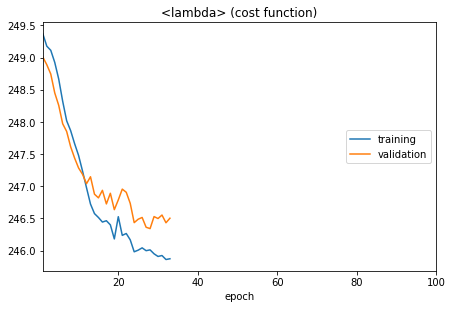

<lambda> (cost function):
training   (min:  245.860, max:  249.369, cur:  245.872)
validation (min:  246.341, max:  249.008, cur:  246.502)
Epoch 00033: early stopping


In [15]:
from livelossplot.keras import PlotLossesCallback
earlystopper = EarlyStopping(patience=5, verbose=1)
results = train_model.fit([X_train, Y_train], Y_train, validation_split=0.1, epochs=100, batch_size=100, callbacks=[PlotLossesCallback(), earlystopper])
#results = train_model.fit([X_train, Y_train], Y_train, validation_split=0.1, epochs=5, batch_size=100, callbacks=cbks)

In [17]:
from keras.utils import plot_model
plot_model(student_model, to_file='student.png')

In [18]:
student_model.save("student.h5")

In [19]:
train_model.save("train_model.h5")

In [19]:
# Get and resize test images
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    path = path_test
    img = load_img(path + "/images/" + id_)
    x = img_to_array(img)[:,:,1]
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (128, 128, 1), mode="constant", preserve_range=True)
    X_test[n] = x
    
print("Done!")

Getting and resizing test images ... 


C:\Users\G2\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



Done!


In [7]:
model = load_model('student.h5', custom_objects={'mean_iou': mean_iou})
#preds_train = student_model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
#preds_val = student_model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
#preds_test = student_model.predict(X_test, verbose=1)
preds_train = model.predict(X_train, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
#preds_val_t = (preds_val > 0.5).astype(np.uint8)
#preds_test_t = (preds_test > 0.5).astype(np.uint8)

4000/4000 [==============================] - ETA: 3: - ETA: 32s - ETA: 16 - ETA: 11 - ETA: 8 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 3s 766us/step


# 自作IOU

In [11]:
preds_train_t.shape

(4000, 128, 128, 1)

In [85]:
preds_train_tt = preds_train_t.reshape(4000,128, 128)
print(preds_train_tt.shape)
print(Y_train_t.shape)

(4000, 128, 128)
(4000, 128, 128)


In [91]:
iou = []
mean_iou = 0
for i in range(preds_train_tt.shape[0]):
    temp_or = np.sum(np.logical_or(Y_train_t[i], preds_train_tt[i]))
    if (np.unique(temp_or) == 0):
        tmp = 1
    else:
        tmp = np.nansum(np.logical_and(Y_train_t[i], preds_train_tt[i])) / temp_or
    iou.append(tmp)

mean_iou = np.mean(np.vstack(iou))

In [92]:
mean_iou

0.27922485471552416

In [54]:
np.where( np.isnan(Y_train_t))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [51]:
for i in iou:
    #print(i)
    if i is np.nan:
        print(i)

In [58]:
np.where(np.isnan(np.vstack(iou)))

(array([  71,  178,  218,  226,  269,  383,  398,  414,  455,  456,  463,
         483,  503,  600,  653,  706,  820,  842,  900,  948,  962,  976,
         995, 1193, 1221, 1319, 1333, 1338, 1345, 1366, 1369, 1410, 1425,
        1453, 1509, 1606, 1633, 1704, 1710, 1795, 1817, 1839, 1978, 2051,
        2114, 2125, 2147, 2197, 2259, 2284, 2326, 2346, 2359, 2389, 2415,
        2551, 2556, 2570, 2577, 2579, 2593, 2600, 2638, 2660, 2684, 2687,
        2696, 2729, 2735, 2787, 2794, 2833, 2850, 2859, 2898, 2920, 2951,
        2993, 3037, 3040, 3062, 3065, 3135, 3194, 3249, 3258, 3266, 3291,
        3346, 3388, 3394, 3444, 3503, 3509, 3575, 3608, 3616, 3624, 3686,
        3750, 3752, 3783, 3787, 3893, 3992], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [66]:
mean_iou

nan

In [75]:
if np.unique(Y_train_t[218]) == 0:
    print("t")

t


In [65]:
np.unique(preds_train_tt[218])

array([0], dtype=uint8)

In [70]:
np.array(0) / np.array(0)

C:\Users\G2\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


nan

In [31]:
preds_train_t.shape

(4000, 128, 128, 1)

In [42]:
preds_train_tt = preds_train_t.reshape(4000,128, 128)

In [9]:
Y_train_t = np.squeeze(Y_train).astype(np.float32)

In [50]:
Y_train_t

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [46]:
np.sum(np.logical_and(Y_train_t, preds_train_tt))

10293458

In [47]:
128*128*4000

65536000

In [ ]:
10293458
65536000

In [48]:
np.sum(np.logical_or(Y_train_t, preds_train_tt))

21688135

In [21]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in tnrange(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [22]:
preds_test_upsampled[0].shape

(101, 101)

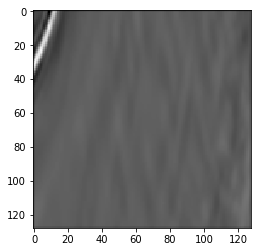

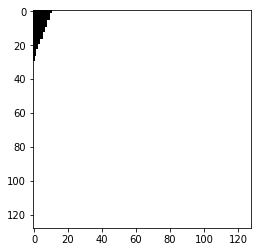

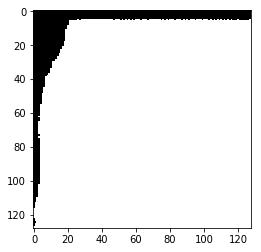

In [37]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
ix = 1271
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()
tmp = np.squeeze(preds_train_t[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

988 722 2277 2351 1883 1353 2989 1387 192 1476 2762 1649 1271

In [20]:
ix

2762

In [24]:
ix

1271

In [ ]:
from keras.utils import plot_model
plot_model(student_model, to_file='smoll_student.png')